### __Libraries__

In [1]:
library(tidyverse)
library(reshape2)

DiagnosisPalette = c('#5CB2EB','#F0484E','#FBE77C')
names(DiagnosisPalette) <- c("MIS-C","COVID-19","Control_Non-inflammatory")

suppressMessages(source("../0_support-files/theme_CRP-MISC.R"))


method = "simpson"


CELLTYPES <- c('Intrahepatic.cholangiocyte','NK.Cell','Monocyte','Macrophage','Secretory.cell','Respiratory.ciliated.cell',
               'Ionocyte.luminal.epithelial.cell.of.mammary.gland','Fibroblast.mesenchymal.stem.cell','Respiratory.secretory.cell',
               'Mast.cell','Basal.cell','Endothelial.cell','neutrophil','B.cell','T.Cell','Erythrocyte.erythroid.progenitor','Platelet',
               'Basophil','Stromal.cell','Mature.conventional.dendritic.cell','Adventitial.cell','Gland.cell','Salivary.bronchial.secretory.cell',
               'Pericyte.cell','Myeloid.progenitor','Pancreatic.Stellate.cell','Pancreatic.alpha.beta.cell','Basal.prostate.cell',
               'Prostate.epithelia','Salivary.gland.cell','Intestinal.enterocyte','Intestinal.secretory.cell','Intestinal.tuft.cell',
               'Type.II.Pneumocyte','Cell.of.skeletal.muscle','Schwann.cell','Tendon.cell','Mesothelial.cell','Plasmablast',
               'Kidney.epithelial.cell','Thymocyte')

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
paired = read.delim("../1_sample-data/paired_sample_key.tsv") %>% 
    filter(!is.na(cfrna_sample_id) & !is.na(wbrna_sample_id)) %>% 
    select(cfrna_sample_id, wbrna_sample_id)
head(paired)

,cfrna_sample_id,wbrna_sample_id
,<chr>,<chr>
3,prevail_cu_cfrna_199,PV351
6,prevail_cu_cfrna_216,PV352
7,prevail_cu_cfrna_219,PV353
21,prevail_cu_cfrna_203,PV359
22,prevail_cu_cfrna_209,PV364
53,prevail_cu_cfrna_124,PV156


### __cfRNA__

In [3]:
cf_meta <- read.csv("../1_sample-data/STable6_cfrna-samples.csv") %>%  mutate(PTID_TIME = paste0(PTID,"_",timepoint)) 
cf_decon <- cf_meta[,c("cfrna_sample_id",CELLTYPES)]

cf_alpha <- data.frame(as.matrix((vegan::diversity(x=cf_decon[,-1], index = method))))

rownames(cf_alpha) <- cf_decon$cfrna_sample_id
colnames(cf_alpha) <- paste0(method,"_cfrna")


cf_all <- merge(cf_meta,cf_alpha,by.x="cfrna_sample_id",by.y=0) %>% select(cfrna_sample_id, simpson_cfrna,Diagnosis,timepoint)

cf_all <- cf_all %>% filter(timepoint == "acute" | Diagnosis == "Control_Non-inflammatory")

cf_all %>% head()

,cfrna_sample_id,simpson_cfrna,Diagnosis,timepoint
,<chr>,<dbl>,<chr>,<chr>
1,prevail_cu_cfrna_108,0.9060655,MIS-C,acute
2,prevail_cu_cfrna_112,0.6509593,COVID-19,acute
3,prevail_cu_cfrna_131,0.5160146,Control_Non-inflammatory,Not-hospitalized
4,prevail_cu_cfrna_148,0.5156292,Control_Non-inflammatory,Not-hospitalized
5,prevail_cu_cfrna_149,0.2722748,Control_Non-inflammatory,Not-hospitalized
6,prevail_cu_cfrna_150,0.7442220,Control_Non-inflammatory,Not-hospitalized


### __wbRNA__

In [4]:
wb_meta <- read.csv("../1_sample-data/STable7_wbrna-samples.csv") %>%  mutate(PTID_TIME = paste0(PTID,"_",timepoint))
wb_decon <- wb_meta[,c("wbrna_sample_id",CELLTYPES)]



wb_alpha <- data.frame(as.matrix((vegan::diversity(x=wb_decon[,-1], index = method))))

rownames(wb_alpha) <- wb_decon$wbrna_sample_id
colnames(wb_alpha) <- paste0(method,"_wbrna")


wb_all <- merge(wb_meta,wb_alpha,by.x="wbrna_sample_id",by.y=0) %>% select(PTID,wbrna_sample_id, simpson_wbrna,Diagnosis,timepoint)

wb_all <- wb_all %>% filter(timepoint == "acute" | Diagnosis == "Control_Non-inflammatory")

wb_all %>% head()

,PTID,wbrna_sample_id,simpson_wbrna,Diagnosis,timepoint
,<chr>,<chr>,<dbl>,<chr>,<chr>
1,Patient218,PV1,0.6992987,COVID-19,acute
2,Patient77,PV100,0.2341206,MIS-C,acute
3,Patient79,PV101,0.8853703,MIS-C,acute
4,Patient80,PV102,0.8788476,MIS-C,acute
5,Patient82,PV103,0.8067845,MIS-C,acute
6,Patient83,PV104,0.8095330,MIS-C,acute


### __merge__

In [5]:
cf_all_ids <- merge(cf_all, paired, by="cfrna_sample_id")

com_all <- merge(wb_all,cf_all_ids, by = c("wbrna_sample_id","Diagnosis","timepoint")) %>%
    filter(timepoint == "acute" | Diagnosis == "Control_Non-inflammatory") %>%
    select(PTID, simpson_wbrna, simpson_cfrna, Diagnosis)
# com_all %>% head()
# com_all %>% nrow()

com_all_melt <- melt(com_all, id.vars = c("PTID","Diagnosis")) %>% 
    mutate(variable = factor(variable, levels = c("simpson_cfrna","simpson_wbrna")))

# com_all_melt %>% head()

### __Analysis__

In [6]:
ADD_ON <- list(geom_boxplot(outlier.shape = NA,color="black",size = 0.5),
               geom_point(size = 0.5),
               geom_line(aes(group=PTID),size = 0.2),
               theme_prevail(),
                theme(legend.position = "none",
                    axis.title.y = element_blank(),
                    axis.title.x = element_blank(),
                    axis.text.x = element_blank(),
                    panel.grid.minor = element_blank()),
                scale_x_discrete(guide = guide_axis(n.dodge = 2)),
               scale_fill_manual(values=DiagnosisPalette) ,
#                scale_y_continuous(breaks = seq(0,1,length.out  = 4)),
               coord_cartesian(ylim = c(0,1))
              )

In [9]:
WIDTH = 1.3
HEIGHT = 1.35

In [10]:
com_all_melt %>% head()

,PTID,Diagnosis,variable,value
,<chr>,<chr>,<fct>,<dbl>
1,Patient77,MIS-C,simpson_wbrna,0.2341206
2,Patient79,MIS-C,simpson_wbrna,0.8853703
3,Patient83,MIS-C,simpson_wbrna,0.8095330
4,Patient84,MIS-C,simpson_wbrna,0.8578257
5,Patient86,MIS-C,simpson_wbrna,0.7485490
6,Patient92,MIS-C,simpson_wbrna,0.8692290


In [11]:
pdf(file="plots/panelD_control.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

com_all_melt %>% 
    filter(Diagnosis == "Control_Non-inflammatory") %>% 
    ggplot(aes(x=variable,y=value,fill=Diagnosis))+
    ADD_ON

dev.off()

tmp <- com_all %>% 
    filter(Diagnosis == "Control_Non-inflammatory")

nrow(tmp)

wilcox.test(tmp$simpson_wbrna,tmp$simpson_cfrna,paired=TRUE)

png 
  2

[1] 12


	Wilcoxon signed rank exact test

data:  tmp$simpson_wbrna and tmp$simpson_cfrna
V = 77, p-value = 0.0009766
alternative hypothesis: true location shift is not equal to 0


In [12]:
pdf(file="plots/panelD_covid.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

com_all_melt %>% 
    filter(Diagnosis == "COVID-19") %>% 
    ggplot(aes(x=variable,y=value,fill=Diagnosis))+
    ADD_ON

dev.off()

tmp <- com_all %>% 
    filter(Diagnosis == "COVID-19")

nrow(tmp)

wilcox.test(tmp$simpson_wbrna,tmp$simpson_cfrna,paired=TRUE)

png 
  2

[1] 12


	Wilcoxon signed rank exact test

data:  tmp$simpson_wbrna and tmp$simpson_cfrna
V = 66, p-value = 0.03418
alternative hypothesis: true location shift is not equal to 0


In [13]:
pdf(file="plots/panelD_misc.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

com_all_melt %>% 
    filter(Diagnosis == "MIS-C") %>% 
    ggplot(aes(x=variable,y=value,fill=Diagnosis))+
    ADD_ON

dev.off()

tmp <- com_all %>% 
    filter(Diagnosis == "MIS-C")

wilcox.test(tmp$simpson_wbrna,tmp$simpson_cfrna,paired=TRUE)

png 
  2


	Wilcoxon signed rank exact test

data:  tmp$simpson_wbrna and tmp$simpson_cfrna
V = 296, p-value = 0.357
alternative hypothesis: true location shift is not equal to 0


---
---

In [12]:
library(rstatix)
library(ggpubr)


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [13]:
ADD_ON2 <- list(geom_boxplot(aes(fill=Diagnosis),outlier.shape = NA,color="black",size = 0.5),
               geom_point(size = 0.5),
               geom_line(aes(group=PTID),size = 0.2),
               theme_prevail(),
                theme(legend.position = "none",
                    axis.title.y = element_blank(),
                    axis.title.x = element_blank(),
                    axis.text.x = element_blank(),
                    panel.grid.minor = element_blank()),
                scale_x_discrete(guide = guide_axis(n.dodge = 2)),
               scale_fill_manual(values=DiagnosisPalette) ,
#                scale_y_continuous(breaks = seq(0,1,length.out  = 4)),
               coord_cartesian(ylim = c(0,1))
              )

YLIM = 1.3
WIDTH = 1.7
HEIGHT = 1.35

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



png 
  2

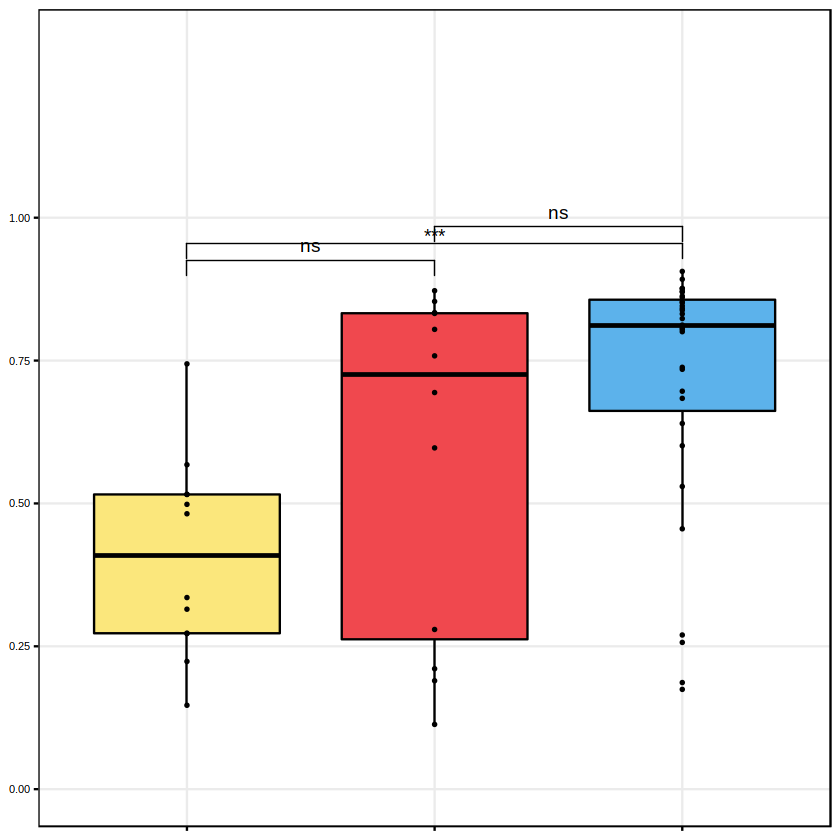

In [14]:
bxplt <- com_all %>% 
    filter(Diagnosis != "Control_Inflammatory") %>%
    ggplot(aes(x=Diagnosis, y=simpson_cfrna))+
    ADD_ON2

stat.test <- data.frame(com_all) %>% filter(Diagnosis != "Control_Inflammatory") %>%
        wilcox_test(simpson_cfrna ~ Diagnosis, paired = FALSE)  %>% 
        adjust_pvalue(method = "BH") %>% 
        add_significance("p.adj") %>% 
        add_xy_position(x = "Diagnosis") 

bxplt <- bxplt +  
stat_pvalue_manual(stat.test, label = "p.adj.signif")+ 
coord_cartesian(ylim = c(0,YLIM)) + scale_y_continuous(breaks = seq(0, 1, by = .25))

bxplt


pdf(file=paste0("plots/SupPanelF_cfrna.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

bxplt

dev.off() 


In [16]:


library(ggpubr)
library(rstatix)


stat.test <- com_all %>% 
    filter(Diagnosis != "Control_Inflammatory") %>% 
    wilcox_test( simpson_cfrna ~ Diagnosis, paired = FALSE) %>% 
    adjust_pvalue(method = "BH") %>% 
    add_significance("p.adj")

stat.test


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
simpson_cfrna,Control_Non-inflammatory,COVID-19,12,12,44,0.114000,0.171000,ns
simpson_cfrna,Control_Non-inflammatory,MIS-C,12,31,56,0.000212,0.000636,***
simpson_cfrna,COVID-19,MIS-C,12,31,135,0.174000,0.174000,ns


Coordinate system already present. Adding new coordinate system, which will replace the existing one.

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



png 
  2

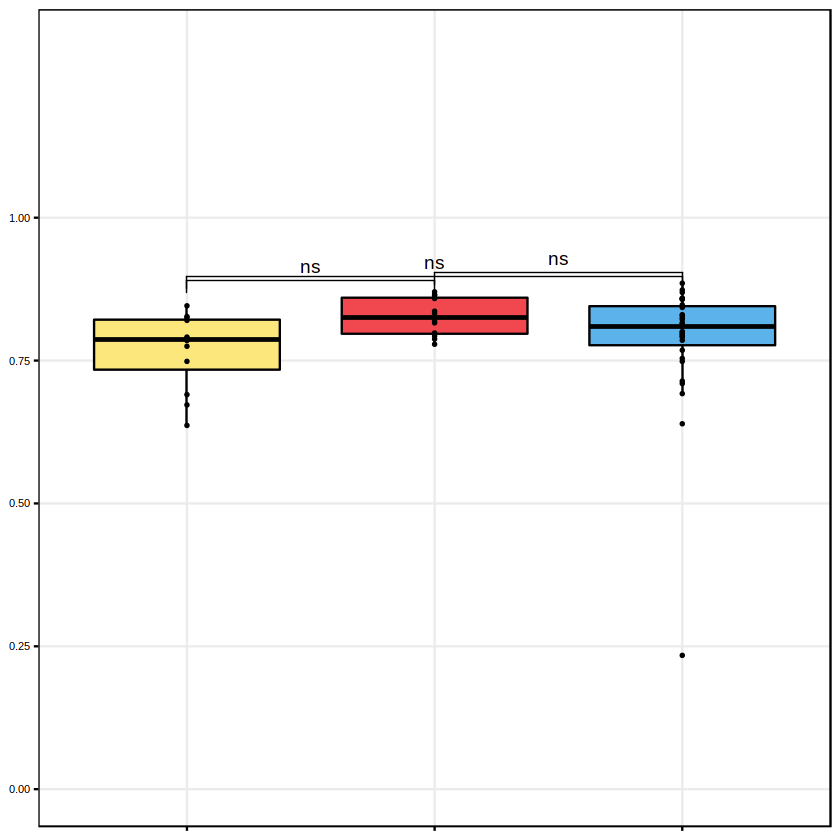

In [16]:
bxplt <- com_all %>% 
    filter(Diagnosis != "Control_Inflammatory") %>%
    ggplot(aes(x=Diagnosis, y=simpson_wbrna))+
    ADD_ON2

stat.test <- data.frame(com_all) %>% filter(Diagnosis != "Control_Inflammatory") %>%
        wilcox_test(simpson_wbrna ~ Diagnosis, paired = FALSE)  %>% 
        adjust_pvalue(method = "BH") %>% 
        add_significance("p.adj") %>% 
        add_xy_position(x = "Diagnosis") 

bxplt <- bxplt +  
stat_pvalue_manual(stat.test, label = "p.adj.signif")+ 
coord_cartesian(ylim = c(0,YLIM)) + scale_y_continuous(breaks = seq(0, 1, by = .25))

bxplt


pdf(file=paste0("plots/SupPanelF_wbrna.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

bxplt

dev.off() 